In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


plt.style.use("seaborn-v0_8-whitegrid")


In [3]:
import pandas as pd

df = pd.read_csv("wroclaw_ml_hourly.csv", parse_dates=["time"])
df = df.set_index("time").sort_index()
df.head(3)

,temp,rhum,prcp,snwd,wdir,wspd,wpgt,pres,cldc,coco,year,month,day,day_of_year,hour,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,4.2,94.0,0.0,0,240.0,14.4,0.0,1021.4,8,NaN,2005,1,1,1,0,0.000000,1.000000
2005-01-01 01:00:00,4.5,92.0,0.0,0,230.0,10.8,0.0,1021.2,8,NaN,2005,1,1,1,1,0.258819,0.965926
2005-01-01 02:00:00,5.0,87.0,0.0,0,240.0,11.2,0.0,1020.9,7,NaN,2005,1,1,1,2,0.500000,0.866025


In [4]:
# Smaller df for experiments
df = df.loc["2015-01-01":"2017-12-31"]
# df = df.loc["2015-01-01":"2015-12-31"]



In [5]:
np.sum(df.isna())

/home/werka/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


temp               0
rhum               0
prcp               0
snwd               0
wdir             209
wspd               0
wpgt               0
pres               0
cldc               0
coco           22793
year               0
month              0
day                0
day_of_year        0
hour               0
hour_sin           0
hour_cos           0
dtype: int64

In [6]:
df = df[~df.index.duplicated()]
# df = df.asfreq("h")
df = df.resample("3h").mean()
df = df.ffill()
np.sum(df.isna())

temp              0
rhum              0
prcp              0
snwd              0
wdir              0
wspd              0
wpgt              0
pres              0
cldc              0
coco           2599
year              0
month             0
day               0
day_of_year       0
hour              0
hour_sin          0
hour_cos          0
dtype: int64

In [7]:
y = df["temp"]
exog = df[[
    # "hour_sin",
    # "hour_cos",
    # "month",
    # "day_of_year",
    "rhum",
    "wspd",
    "pres"
]]

Text(0.5, 1.0, 'Temperature')

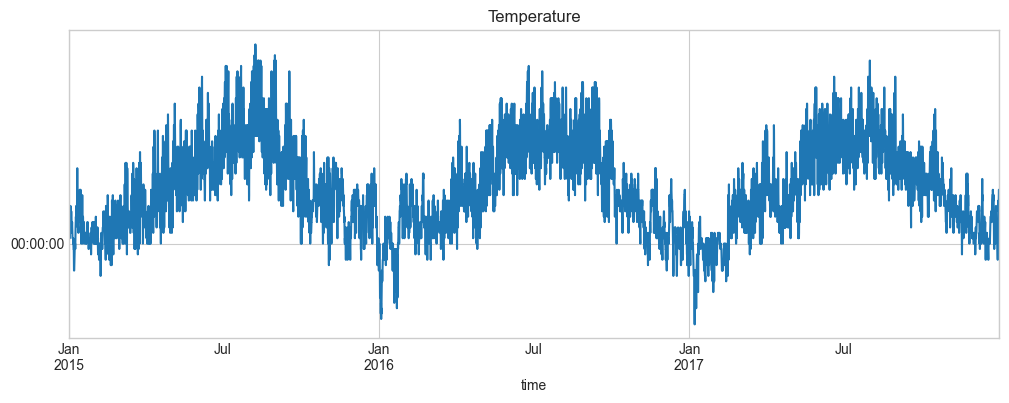

In [8]:
pd.to_datetime(y, errors='coerce').plot(figsize=(12,4))
plt.title("Temperature")


Stacjonarność:
$p<0.05$ powinno być ok

In [9]:
adf = adfuller(y)
print(f"ADF p-value: {adf[1]}")


ADF p-value: 0.0008375222581261256


In [10]:
y = pd.to_numeric(y, errors='coerce')
exog = exog.apply(pd.to_numeric, errors='coerce')
y = y.ffill().bfill()
exog = exog.ffill().bfill()

last_timestamp = df.index.max()
split = last_timestamp - pd.Timedelta(days=30)

y_train = y.loc[:split]
y_test  = y.loc[split:]

exog_train = exog.loc[:split]
exog_test  = exog.loc[split:]

`seasonal_order=(P, D, Q, s)`
- P = Liczba sezonowych opóźnień autoregresyjnych, tj. $y_{t-s}, y_{t-2s}, \dots$.
- D = Ile razy wykonywane jest różnicowanie sezonowe: $y_t - y_{t-s}$
- Q = Liczba sezonowych opóźnień składnika błędu: $\varepsilon_{t-s}, \varepsilon_{t-2s}, \dots$
- s = Liczba próbek w jednym okresie sezonowym.

`order=(p, d, q)`
- p = Liczba opóźnionych obserwacji $y_{t-1}, \dots, y_{t-p}$ użytych w modelu.
- d = Ile razy sygnał jest różnicowany, aby uzyskać stacjonarność.
- q = Liczba opóźnionych składników błędu $\varepsilon_{t-1}, \dots, \varepsilon_{t-q}$.

In [11]:
p = 7
d = 0
q = 7

P = 5
D = 0
Q = 5
s = 24

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result = model.fit(maxiter=20, disp=True)
result.summary()

KeyboardInterrupt: 

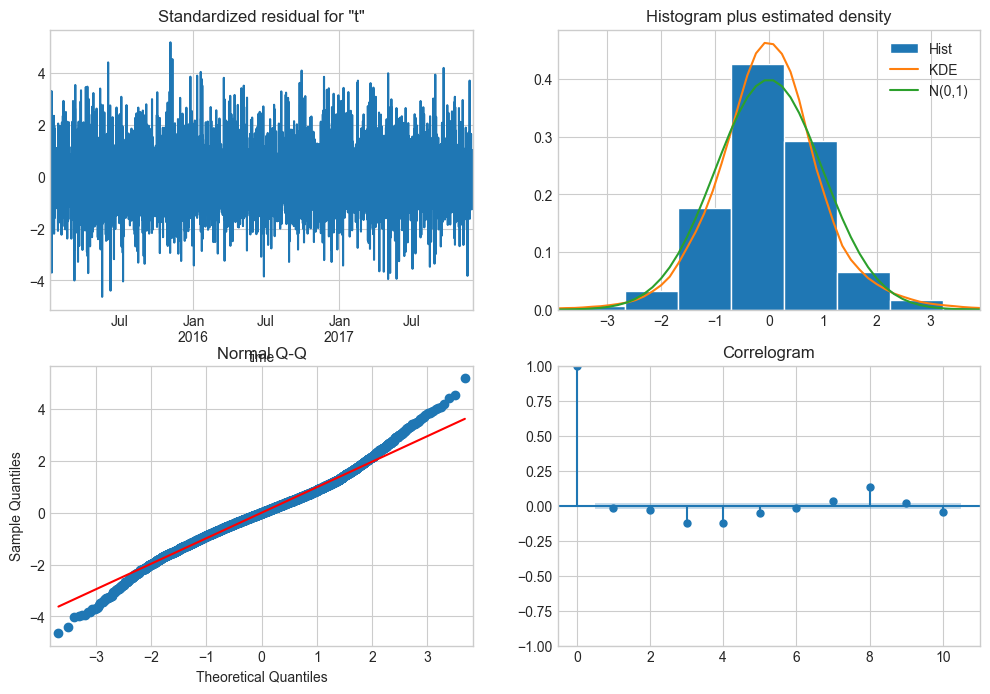

In [ ]:
result.plot_diagnostics(figsize=(12,8))
plt.show()

prognoza

In [ ]:
forecast = result.get_forecast(
    steps=len(y_test),
    exog=exog_test
)

y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

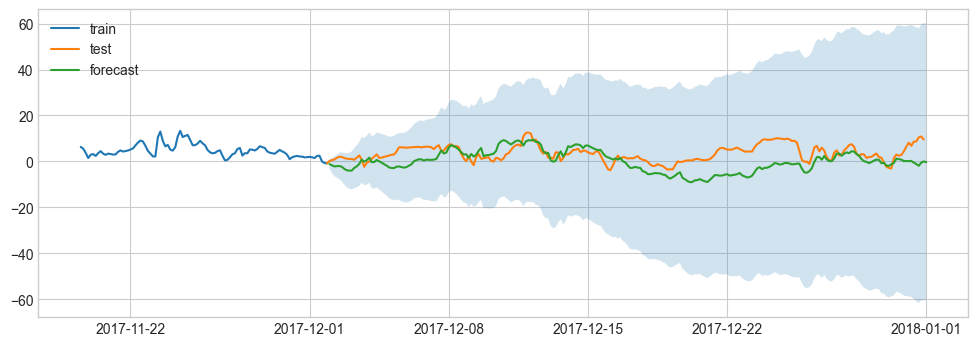

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_train.tail(100).index, y_train.tail(100), label="train")
plt.plot(y_test.index, y_test, label="test")
plt.plot(y_pred.index, y_pred, label="forecast")
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.2
)
plt.legend()
plt.show()


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 4.744766932894523
RMSE: 5.9068534113661535
